# Import relevant packages: numpy, matplotlib, iris, windsparm, aeolus, cartopy

In [10]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs  
from matplotlib import ticker, cm

import aeolus
from aeolus.calc.stats import cumsum, spatial
from aeolus.coord import volume_weights_cube, area_weights_cube, coord_delta_to_cube, interp_cube_from_height_to_pressure_levels
from aeolus.const import init_const
pcb_const=init_const('proxb')




In [3]:
warnings.filterwarnings("ignore")


# Load the data: ask for availability of dataset and change to local directories

In [25]:
pcb_11 = iris.load('../../eccent/data/pcb_synch_8040_600.nc')
pcb_32 = iris.load('../data/pcb_32_fix_17120_120.nc')
pcb_32_rates = iris.load('../data/pcb_32_17120_120_rates.nc')#Cube with additional reaction rates included

ut_scale(): NULL factor argument
ut_raise(): NULL unit argument


# Renaming vertical coordinate and defining relevant functions for calculating spatial averages, volumes of gridboxes, and densities of chemical species

In [26]:
def newheight(cubes, max_tslice=-1):            
    for cube in cubes:
        if cube.coords()[1].long_name=='Hybrid height':
            height_new = cube.coord('Hybrid height')
            height_new.rename('level_height')
newheight(pcb_11)
newheight(pcb_32)
newheight(pcb_32_rates)

In [29]:
def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def hemisphere_sep(cube):
    daycube=cube.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= 90))
    nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
                                    latitude=lambda v: -90 <= v <= 90)) 
    daymean = meridional_mean(zonal_mean(daycube))
    nightmean = meridional_mean(zonal_mean(nightcube)) 
    return daymean, nightmean

def height_to_pressure(cube, pressurecube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = pressurecube.interpolate(height, iris.analysis.Linear())
    rflux_reg=interp_cube_from_height_to_pressure_levels(cube, p_reg, meridional_mean(zonal_mean(p_reg)).data)
    return rflux_reg 

def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume

def vmr_molec(cube, p_cube, t_cube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = p_cube.interpolate(height, iris.analysis.Linear())
    volume = volume_weights_cube2(cube)
    nair=(p_reg*volume)/((1.38*10**(-23))*t_cube) #nair in molec/gridbox
    cube_molec = cube*nair/volume #n_o3 in molec/m3
    cube_molec *= 1e-6
    return cube_molec

# Plotting of hemispherically averaged temperature, cloud distributions, and chemical abundances as a function of pressure, as shown in Figure 5.

[4.28750927e-05]
[4.82648461e-05]
[4.28750927e-05]
[4.82648461e-05]
[4.28750927e-05]
[4.82648461e-05]
[4.28750927e-05]
[4.82648461e-05]
[4.28750927e-05]
[4.82648461e-05]
[4.28750927e-05]
[4.82648461e-05]
[4.28750927e-05]
[4.82648461e-05]
[4.28750927e-05]
[4.82648461e-05]
[4.28750927e-05]
[4.82648461e-05]


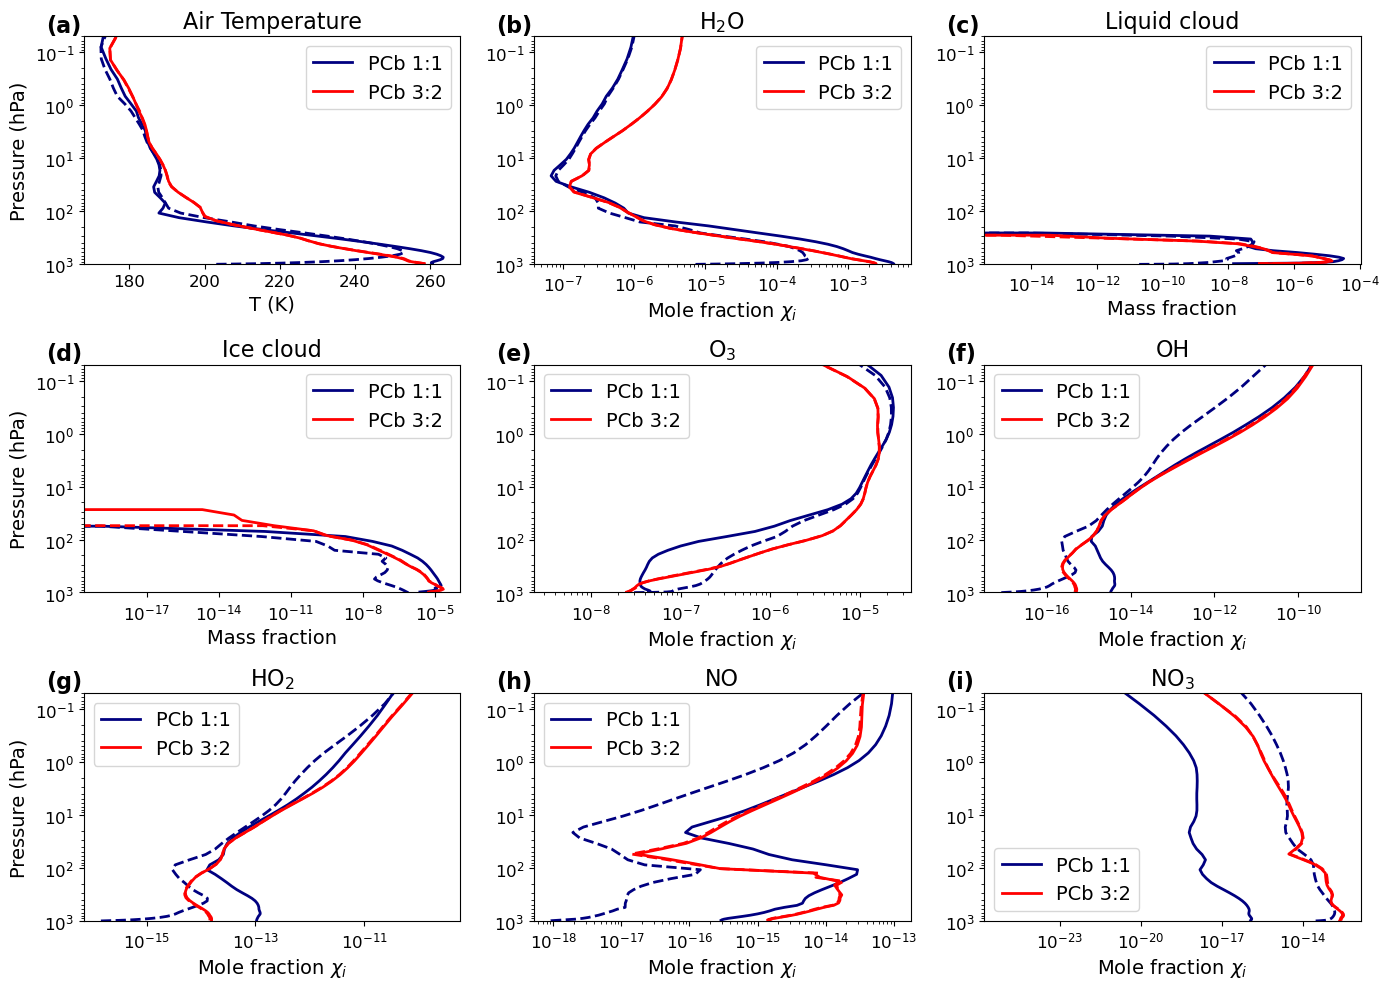

In [22]:

def plot_mixratz(cubes, species_names=['O3'], time_mean=False, save=False):
    num_species = len(species_names)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))
    colors = ['navy', 'red'] #    colors = ['navy', 'blue','red','maroon']
    for idx, species_name in enumerate(species_names):
        row = idx // 3
        col = idx % 3

        varcubes_list = []
        pres_cube_list = []
        temp_cube_list = []
        label_list = ['PCb 1:1', 'PCb 3:2']
        num_cubes_to_plot = 4 if row < 1 and col < 2 else 3
        
        for cube_idx, cube in enumerate(cubes[:num_cubes_to_plot]):
            for cube_inner in cube:
                if cube_inner.standard_name == 'air_pressure':
                    pres_cube = cube_inner[:,:,:,:].copy()
                    pres_cube = pres_cube.collapsed('t', iris.analysis.MEAN)
                    pres_cube_list.append(pres_cube)
                elif cube_inner.long_name == f'{species_name} MASS MIXING RATIO':
                    if species_name == 'O3':
                        cube1 = cube_inner[:,:,:,:].copy()*29.3/48
                    if species_name == 'OH':
                        cube1 = cube_inner[:,:,:,:].copy()*29.3/17.008
                    if species_name == 'HO2':
                        cube1 = cube_inner[:,:,:,:].copy()*29.3/33.00674
                    if species_name == 'NO':
                        cube1 = cube_inner[:,:,:,:].copy()*29.3/30.01
                    if species_name == 'NO2':
                        cube1 = cube_inner[:,:,:,:].copy()*29.3/46.0055
                    if species_name == 'NO3':
                        cube1 = cube_inner[:,:,:,:].copy()*29.3/62.0049
                    cube1 = cube1.collapsed('t', iris.analysis.MEAN)
                    varcubes_list.append(cube1)
                elif cube_inner.standard_name == f'{species_name}':
                    if species_name== 'specific_humidity':
                        cube1 = cube_inner[:,:,:,:].copy()*29.3/18.01528
                    else:
                        cube1 = cube_inner[:,:,:,:].copy()
                    cube1 = cube1.collapsed('t', iris.analysis.MEAN)
                    varcubes_list.append(cube1)
        for i in range(len(varcubes_list)):
            height = [('level_height', varcubes_list[i].coord('level_height').points)]
            cube_temp = height_to_pressure(varcubes_list[i], pres_cube_list[i])

            cube_temp_term1, cube_temp_term2 = hemisphere_sep(cube_temp)
            print(cube_temp_term1[-1].coord('air_pressure').points/100)
            color = f"C{i}"
            #print(o3_term1)
            axes[row, col].plot(cube_temp_term1[:].data, cube_temp_term1.coord("air_pressure").points / 100,color=colors[i],lw=2, label=label_list[i])# label=f'Cube {i+1}')
            axes[row, col].plot(cube_temp_term2[:].data, cube_temp_term2.coord("air_pressure").points / 100,color=colors[i],lw=2, ls='--')

        axes[row,col].set_title(f'{species_name}', fontsize=16)
        axes[row,col].set_xlabel('Mole fraction $\chi_{i}$', fontsize=14)
        axes[0,0].set_ylabel('Pressure (hPa)', fontsize=14)
        axes[1,0].set_ylabel('Pressure (hPa)', fontsize=14)
        axes[2,0].set_ylabel('Pressure (hPa)', fontsize=14)
        axes[row,col].tick_params(labelsize=12)
        axes[row,col].legend(loc='best', fontsize=14)
        axes[row,col].set_xscale('log')
        axes[row,col].set_yscale('log')
        if species_name=='air_temperature':
                axes[row,col].set_xlabel('T (K)', fontsize=14)
                axes[row,col].set_xscale('linear')
                axes[row,col].set_title('Air Temperature', fontsize=16)
        if species_name=='specific_humidity':
                axes[row,col].set_title('H$_2$O', fontsize=16)
        if species_name=='O3':
                axes[row,col].set_title('O$_3$', fontsize=16)
        if species_name=='HO2':
                axes[row,col].set_title('HO$_2$', fontsize=16)
        if species_name=='NO3':
                axes[row,col].set_title('NO$_3$', fontsize=16)            
        if species_name=='mass_fraction_of_cloud_liquid_water_in_air':
                axes[row,col].set_title('Liquid cloud', fontsize=16)
                axes[row,col].set_xlabel('Mass fraction', fontsize=14)
        if species_name=='mass_fraction_of_cloud_ice_in_air':
                axes[row,col].set_title('Ice cloud', fontsize=16)
                axes[row,col].set_xlabel('Mass fraction', fontsize=14)                
        axes[row,col].invert_yaxis()
        axes[row,col].set_ylim(1e3,5e-2)
        subplot_label = chr(97 + idx)  # Get alphabet label starting from 'a'
        axes[row, col].text(-0.1, 1.1, f"({subplot_label})", transform=axes[row, col].transAxes,
                            fontsize=16, fontweight='bold', va='top')

    plt.tight_layout()
    if save==True:
        plt.savefig('tair_vmrs_intercomp.pdf', bbox_inches='tight')
    plt.show()

# Example usage with multiple species and cubes
plot_mixratz(cubes=[pcb_11, pcb_32], species_names=['air_temperature', 'specific_humidity', 
                            'mass_fraction_of_cloud_liquid_water_in_air', 'mass_fraction_of_cloud_ice_in_air', 
                                            'O3', 'OH', 'HO2', 'NO', 'NO3'], time_mean=True, save=False)


# Plotting of selected reaction rates as shown in Figure 6.

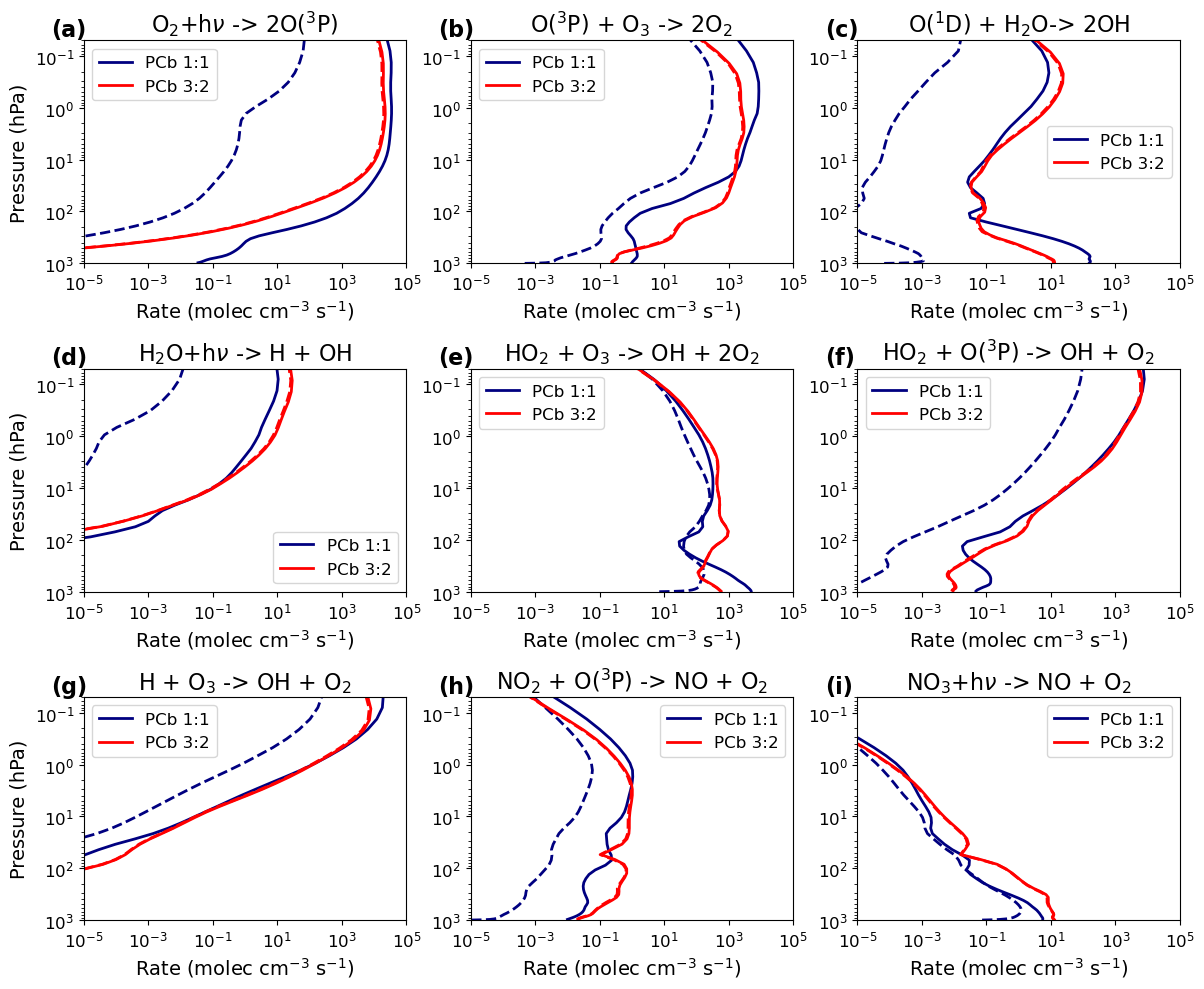

In [27]:

n_a=6.0221409e23 #Avogadro's constant

def plot_rratesz(cubes, stash_number=['50101', '50120'], time_mean=False, save=False):
    num_species = len(stash_number)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    colors = ['navy', 'red'] #    colors = ['navy', 'blue','red','maroon']
    for idx, stash_n in enumerate(stash_number):
        row = idx // 3
        col = idx % 3

        rrates_list = []
        pres_cube_list = []
        volume_cube_list = []
        label_list = ['PCb 1:1', 'PCb 3:2']

        for cube in cubes:
            for cube_inner in cube:
                if cube_inner.standard_name == 'air_pressure':
                    pres_cube = cube_inner[:,:,:,:].copy()
                    pres_cube = pres_cube.collapsed('t', iris.analysis.MEAN)
                    pres_cube_list.append(pres_cube)

                elif cube_inner.long_name == f'Stash code = {stash_n}':
                    rrate = cube_inner[:,:,:,:].copy()
                    rrate = rrate.collapsed('t', iris.analysis.MEAN)
                    rrates_list.append(rrate)
                elif cube_inner.standard_name == 'air_temperature':
                    cube_temp = cube_inner[:,:,:,:].copy()
                    cube_temp = cube_temp.collapsed('t', iris.analysis.MEAN)
                    volume = volume_weights_cube2(cube_temp)
                    volume_cube_list.append(volume)

        
        if stash_n=='50131':
            for i in range(len(rrates_list)):
                height = [('level_height', rrates_list[i].coord('level_height').points)]
                #o3vmr = height_to_pressure(o3vmr_list[i]/(volume_cube_list[i].interpolate(height, iris.analysis.Linear())), pres_cube_list[i])
                rrate = rrates_list[i]/(volume_cube_list[i].interpolate(height, iris.analysis.Linear()))
                rrate_term1, rrate_term2 = hemisphere_sep(rrate)

                color = f"C{i}"
                axes[row, col].scatter(rrate_term1[:].data*1e-6*n_a, rrate_term1.coord("level_height").points / 100, s=100, lw=2, color=colors[i], label=label_list[i])
                axes[row, col].scatter(rrate_term2[:].data*1e-6*n_a, rrate_term2.coord("level_height").points / 100, s=100, lw=2, color=colors[i])
        else:
            for i in range(len(rrates_list)):
                height = [('level_height', rrates_list[i].coord('level_height').points)]
                rrate = height_to_pressure(rrates_list[i]/(volume_cube_list[i].interpolate(height, iris.analysis.Linear())), pres_cube_list[i])

                rrate_term1, rrate_term2 = hemisphere_sep(rrate)
                color = f"C{i}"
                axes[row, col].plot(rrate_term1[:].data*1e-6*n_a, rrate_term1.coord("air_pressure").points / 100, lw=2,color=colors[i], label=label_list[i])
                axes[row, col].plot(rrate_term2[:].data*1e-6*n_a, rrate_term2.coord("air_pressure").points / 100, lw=2,color=colors[i], ls='--')
        axes[row,col].set_xlabel('Rate (molec cm$^{-3}$ s$^{-1}$)', fontsize=14)
        axes[0,0].set_ylabel('Pressure (hPa)', fontsize=14)
        axes[1,0].set_ylabel('Pressure (hPa)', fontsize=14)
        axes[2,0].set_ylabel('Pressure (hPa)', fontsize=14)
        axes[row,col].tick_params(labelsize=12)
        axes[row,col].legend(loc='best', fontsize=12)
        axes[row,col].set_xscale('log')
        axes[row,col].set_yscale('log')
        #if species_name=='air_temperature':
        #        axes[row,col].set_xlabel('T (K)', fontsize=14)
        #        axes[row,col].set_xscale('linear')
        if stash_n== '50101':        
            axes[row,col].set_title(r'O$_2$+h$\nu$ -> 2O($^3$P)', fontsize=16)
        if stash_n== '50120':        
            axes[row,col].set_title(r'O($^3$P) + O$_3$ -> 2O$_2$', fontsize=16)        
        if stash_n== '50514':        
            axes[row,col].set_title(r'H$_2$O+h$\nu$ -> H + OH', fontsize=16)        
        if stash_n== '50503':        
            axes[row,col].set_title(r'OH + O($^3$P) -> H + O$_2$', fontsize=16)        
        if stash_n== '50118':        
            axes[row,col].set_title(r'HO$_2$ + O($^3$P) -> OH + O$_2$', fontsize=16)        
        if stash_n== '50119':        
            axes[row,col].set_title(r'H + O$_3$ -> OH + O$_2$', fontsize=16)        
        if stash_n== '50011':        
            axes[row,col].set_title(r'O($^1$D) + H$_2$O-> 2OH', fontsize=16)        
        if stash_n== '50013':        
            axes[row,col].set_title(r'HO$_2$ + O$_3$ -> OH + 2O$_2$', fontsize=16)        
        if stash_n== '50014':        
            axes[row,col].set_title(r'OH + O$_3$ -> HO$_2$ + O$_2$', fontsize=16)        
        if stash_n== '50117':        
            axes[row,col].set_title(r'NO$_2$ + O($^3$P) -> NO + O$_2$', fontsize=16)        
        if stash_n== '50121':        
            axes[row,col].set_title(r'NO$_3$+h$\nu$ -> NO + O$_2$', fontsize=16)
        if stash_n== '50511':        
            axes[row,col].set_title(r'H + O$_2$ + M -> HO$_2$ + M', fontsize=16)        
        axes[row,col].invert_yaxis()
        axes[row,col].set_ylim(1e3,5e-2)
        axes[row,col].set_xlim(1e-5,1e5)
        if stash_n == '50131':
            axes[row,col].set_xscale('log')
            axes[row,col].set_xlim(1e1,1e8)
        if stash_n == '50502':
            axes[row,col].set_xlim(1e1,1e8)    
        subplot_label = chr(97 + idx)  # Get alphabet label starting from 'a'
        axes[row, col].text(-0.1, 1.1, f"({subplot_label})", transform=axes[row, col].transAxes,
                            fontsize=16, fontweight='bold', va='top')
            
    plt.tight_layout()
    if save==True: 
        plt.savefig('rratesz_intercomp.pdf', bbox_inches='tight')
    plt.show()

# Example usage with multiple species and cubes
plot_rratesz(cubes=[pcb_11, pcb_32_rates], 
             stash_number=['50101', '50120', '50011', '50514', '50013', '50118', '50119', '50117', '50121'], 
             time_mean=True, save=False)
